In [1]:
from transformer_lens import HookedTransformer
import transformer_lens
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import transformer_lens.utils as utils
import hashlib
import yaml 
import hashlib
import pickle
import numpy as np
import matplotlib.pyplot as plt 

/Users/sda1048/Desktop/interp/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Save object to a file
def save_pickle(obj, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(obj, f)

# Load object from a file
def load_pickle(filepath):
    with open(filepath, 'rb') as f:
        return pickle.load(f)

def hash_string(input_string, algorithm='sha256'):
    """
    Hashes a string using the specified algorithm.

    Args:
        input_string: The string to be hashed.
        algorithm: The hashing algorithm to use (e.g., 'sha256', 'md5', 'sha1').
                   Defaults to 'sha256'.

    Returns:
        The hexadecimal representation of the hashed string.
    """

    try:
        # Encode the string to bytes
        encoded_string = input_string.encode('utf-8')

        # Create a hash object using the specified algorithm
        hash_object = hashlib.new(algorithm)

        # Update the hash object with the encoded string
        hash_object.update(encoded_string)

        # Return the hexadecimal representation of the hash
        return hash_object.hexdigest()

    except ValueError:
        return f"Invalid hashing algorithm: {algorithm}"

In [3]:
import circuitsvis as cv


In [4]:
device = utils.get_device()

In [5]:
reference_model_path = 'meta-llama/Llama-3.1-8B'
baseline_model_path = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

In [6]:
baseline_model_hf = AutoModelForCausalLM.from_pretrained(baseline_model_path, torch_dtype=torch.bfloat16)
baseline_model_tokenizer = AutoTokenizer.from_pretrained(baseline_model_path)

baseline_model = HookedTransformer.from_pretrained_no_processing(
    reference_model_path,
    hf_model=baseline_model_hf,
    tokenizer=baseline_model_tokenizer,
    device=device,
    move_to_device=True,
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.83it/s]


Loaded pretrained model meta-llama/Llama-3.1-8B into HookedTransformer


In [7]:
baseline_model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-31): 32 x TransformerBlock(
      (ln1): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): GroupedQueryAttention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out)

In [8]:
def hash_string(input_string, algorithm='sha256'):
    """
    Hashes a string using the specified algorithm.

    Args:
        input_string: The string to be hashed.
        algorithm: The hashing algorithm to use (e.g., 'sha256', 'md5', 'sha1').
                   Defaults to 'sha256'.

    Returns:
        The hexadecimal representation of the hashed string.
    """

    try:
        # Encode the string to bytes
        encoded_string = input_string.encode('utf-8')

        # Create a hash object using the specified algorithm
        hash_object = hashlib.new(algorithm)

        # Update the hash object with the encoded string
        hash_object.update(encoded_string)

        # Return the hexadecimal representation of the hash
        return hash_object.hexdigest()

    except ValueError:
        return f"Invalid hashing algorithm: {algorithm}"

def map_prompt_to_file_string(string):
    assert "<｜User｜>" in string
    simplified_string = string.replace("<｜User｜>", "").replace("<｜Assistant｜>", "").replace("\\", "").lower()
    
    def is_allowed(char):
        return (ord('a')<=ord(char)<=ord('z')) or (ord('0')<=ord(char)<=ord('9'))
    
    hashed = hash_string(string)

    return ''.join([c if is_allowed(c) else '_' for c in simplified_string]).replace("__", "")+str(hashed)

def read_prompts(file_path="reasoning_prompts.txt"):
    """
    Read prompts from a text file and return them as a list of strings.
    
    Args:
        file_path (str): Path to the file containing reasoning prompts
        
    Returns:
        list: A list of strings, each containing a reasoning prompt
    """
    prompts = []
    
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                # Skip empty lines, headers, and category labels
                line = line.strip()
                if (line and 
                    not line.startswith('#') and 
                    not line.startswith('##') and
                    not line == ""):
                    
                    # Extract the prompt text by removing the number and period
                    parts = line.split('. ', 1)
                    if len(parts) > 1 and parts[0].isdigit():
                        prompt = parts[1]
                    else:
                        prompt = line
                        
                    prompts.append(prompt)
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
    except Exception as e:
        print(f"Error reading prompts: {e}")
    
    return prompts

In [9]:
def attention_analysis(
        attention_array: np.ndarray, 
        think_indices: list[int], 
        stop_think_indices: list[int], 
        other_indices: list[int]
    ):
    """
    Look in attention array and quantify the average think, stop think, and other attention values
    for each token, respecting causality.
    
    Args:
        attention_array: 2D array of shape [query_len, key_len] containing attention values
        think_indices: Indices of "think" tokens
        stop_think_indices: Indices of "stop think" tokens
        other_indices: Indices of "other" tokens
    
    Returns:
        tuple of average attention values (think, stop_think, other)
    """
    # Create causal mask (lower triangular matrix)
    causal_mask = np.tril(np.ones(attention_array.shape, dtype=bool))
    
    # Make a copy to avoid modifying the original
    attention_array = attention_array.copy()
    attention_array[~causal_mask] = -1  # Mask out non-causal attention values

    # Collect attention values for each token type
    average_think_value = attention_array[:, think_indices]
    average_think_value = average_think_value[average_think_value >= 0]

    average_stop_think_value = attention_array[:, stop_think_indices]
    average_stop_think_value = average_stop_think_value[average_stop_think_value >= 0]

    average_other_value = attention_array[:, other_indices]
    average_other_value = average_other_value[average_other_value >= 0]
    
    # Handle empty arrays when calculating means
    mean_think = np.mean(average_think_value) if len(average_think_value) > 0 else -1
    mean_stop_think = np.mean(average_stop_think_value) if len(average_stop_think_value) > 0 else -1

    think_stop_think = np.concatenate([average_think_value, average_stop_think_value])
    mean_think_stop_think = np.mean(think_stop_think) if len(think_stop_think) > 0 else -1 
    mean_other = np.mean(average_other_value) if len(average_other_value) > 0 else -1

    if mean_think>0 and mean_other>0:
        mean_think_ratio = mean_think / mean_other
    else:
        mean_think_ratio = None
    
    if mean_stop_think>0 and mean_other>0:
        mean_stop_think_ratio = mean_stop_think / mean_other
    else:
        mean_stop_think_ratio = None
    
    if mean_think_stop_think>0 and mean_other>0:
        mean_think_stop_think_ratio = mean_think_stop_think / mean_other
    else:
        mean_think_stop_think_ratio = None

    mean_values = (mean_think, mean_stop_think, mean_think_stop_think, mean_other)
    ratio_values = (mean_think_ratio, mean_stop_think_ratio, mean_think_stop_think_ratio)
    
    return mean_values, ratio_values

In [10]:
def collect_think_attention(model, strings):
    """
    for each (layer_idx, head_idx) combination 
    compute the attention on each token 
    """
    attention_collection_dict = dict()
    for layer_idx in range(32):
        for head_idx in range(32):
            attention_collection_dict[(layer_idx, head_idx)] = {
                'mean_think_ratio':[],
                'mean_stop_think_ratio':[],
                'mean_think_stop_think_ratio':[]
            }
    
    for string in strings:
        assert "<｜User｜>" in string 
        assert "<｜Assistant｜>" in string 

        string_tokens =model.to_tokens(string)

        think_token = model.to_tokens("<think>")[0][-1]
        stop_think_token = model.to_tokens("</think>")[0][-1]

        think_indices = [i for i, v in enumerate(string_tokens[0]) if think_token==v]
        stop_think_indices = [i for i, v in enumerate(string_tokens[0]) if stop_think_token==v]
        non_special_indices = [i for i, v in enumerate(string_tokens[0]) if v<128000]

        test_logits, test_cache = model.run_with_cache(string_tokens, remove_batch_dim=True)

        """
        Now iterate through all layers, and all heads within each layer
        for each layer, compute the total attention weight on <think> </think> and all other rokens
        """
        for layer_idx in range(32):
            attention_pattern = test_cache["pattern", layer_idx, "attn"]
            for head_idx in range(32):
                current_attention = attention_pattern[head_idx].cpu().detach().numpy()

                mean_values, ratio_values = attention_analysis(
                    attention_array=current_attention, 
                    think_indices=think_indices, 
                    stop_think_indices=stop_think_indices, 
                    other_indices=non_special_indices
                )

                mean_think_ratio, mean_stop_think_ratio, mean_think_stop_think_ratio = ratio_values
                
                if mean_think_ratio is not None:
                    attention_collection_dict[(layer_idx, head_idx)]['mean_think_ratio'].append(mean_think_ratio)
                if mean_stop_think_ratio is not None:
                    attention_collection_dict[(layer_idx, head_idx)]['mean_stop_think_ratio'].append(mean_stop_think_ratio)
                if mean_think_stop_think_ratio is not None:
                    attention_collection_dict[(layer_idx, head_idx)]['mean_think_stop_think_ratio'].append(mean_think_stop_think_ratio)

    return attention_collection_dict


load precomputed reasoning strings

In [38]:
precomputed_reasoning_strings = load_pickle("precomputed_reasoning_strings.pkl")

Now we'll collect the data across all reasoning strings 

In [39]:
all_attention_collection_dict=[]

for precomputed_reasoning_string in precomputed_reasoning_strings:
    attention_collection_dict = collect_think_attention(baseline_model, [precomputed_reasoning_string])
    all_attention_collection_dict.append(attention_collection_dict)
    save_pickle(all_attention_collection_dict, "all_attention_collection_dict.pkl")

AssertionError: 

In [32]:
out = load_pickle("all_attention_collection_dict.pkl")

In [33]:
out

[{(0, 0): {'mean_think_ratio': [np.float32(0.43563893)],
   'mean_stop_think_ratio': [],
   'mean_think_stop_think_ratio': [np.float32(0.43563893)]},
  (0, 1): {'mean_think_ratio': [np.float32(0.83415365)],
   'mean_stop_think_ratio': [],
   'mean_think_stop_think_ratio': [np.float32(0.83415365)]},
  (0, 2): {'mean_think_ratio': [np.float32(1.2539)],
   'mean_stop_think_ratio': [],
   'mean_think_stop_think_ratio': [np.float32(1.2539)]},
  (0, 3): {'mean_think_ratio': [np.float32(2.15187)],
   'mean_stop_think_ratio': [],
   'mean_think_stop_think_ratio': [np.float32(2.15187)]},
  (0, 4): {'mean_think_ratio': [np.float32(0.49285936)],
   'mean_stop_think_ratio': [],
   'mean_think_stop_think_ratio': [np.float32(0.49285936)]},
  (0, 5): {'mean_think_ratio': [np.float32(0.5895387)],
   'mean_stop_think_ratio': [],
   'mean_think_stop_think_ratio': [np.float32(0.5895387)]},
  (0, 6): {'mean_think_ratio': [np.float32(1.35069)],
   'mean_stop_think_ratio': [],
   'mean_think_stop_think_rati

In [12]:
attention_collection_dict = collect_think_attention(baseline_model, precomputed_reasoning_strings[:1])

In [16]:
attention_collection_dict

{(0, 0): {'mean_think_ratio': [np.float32(0.43563893)],
  'mean_stop_think_ratio': [],
  'mean_think_stop_think_ratio': [np.float32(0.43563893)]},
 (0, 1): {'mean_think_ratio': [np.float32(0.83415365)],
  'mean_stop_think_ratio': [],
  'mean_think_stop_think_ratio': [np.float32(0.83415365)]},
 (0, 2): {'mean_think_ratio': [np.float32(1.2539)],
  'mean_stop_think_ratio': [],
  'mean_think_stop_think_ratio': [np.float32(1.2539)]},
 (0, 3): {'mean_think_ratio': [np.float32(2.15187)],
  'mean_stop_think_ratio': [],
  'mean_think_stop_think_ratio': [np.float32(2.15187)]},
 (0, 4): {'mean_think_ratio': [np.float32(0.49285936)],
  'mean_stop_think_ratio': [],
  'mean_think_stop_think_ratio': [np.float32(0.49285936)]},
 (0, 5): {'mean_think_ratio': [np.float32(0.5895387)],
  'mean_stop_think_ratio': [],
  'mean_think_stop_think_ratio': [np.float32(0.5895387)]},
 (0, 6): {'mean_think_ratio': [np.float32(1.35069)],
  'mean_stop_think_ratio': [],
  'mean_think_stop_think_ratio': [np.float32(1.350

In [13]:
def plot_ratios(data_dict):
    layers = sorted({layer for (layer, head) in data_dict.keys()})
    heads = sorted({head for (layer, head) in data_dict.keys()})
    num_layers = len(layers)
    num_heads = len(heads)
    
    layer_to_index = {layer: i for i, layer in enumerate(layers)}
    head_to_index = {head: j for j, head in enumerate(heads)}
    
    ratio_think_over_other = np.full((num_layers, num_heads), np.nan)
    ratio_endthink_over_other = np.full((num_layers, num_heads), np.nan)
    ratio_think_and_endthink_over_other = np.full((num_layers, num_heads), np.nan)
    
    for (layer, head), sub_dict in data_dict.items():
        i = layer_to_index[layer]
        j = head_to_index[head]
        try:
            val_think = sub_dict['mean_think_ratio']
            val_endthink = sub_dict['mean_stop_think_ratio']
            val_think_and_endthink = sub_dict['mean_think_stop_think_ratio']
            
            ratio_think_over_other[i, j] = val_think 
            ratio_endthink_over_other[i, j] = val_endthink 
            ratio_think_and_endthink_over_other[i, j] = val_think_and_endthink
        except KeyError:
            continue

    def plot_matrix(matrix, title):
        plt.figure(figsize=(num_heads, num_layers))
        im = plt.imshow(matrix, origin='lower', aspect='auto', interpolation='none')
        cbar = plt.colorbar(im)
        cbar.ax.tick_params(labelsize=16)
        cbar.set_label('Intensity', fontsize=18)
        
        plt.title(title, fontsize=22, pad=20)
        plt.xlabel('Head Index', fontsize=20, labelpad=10)
        plt.ylabel('Layer Index', fontsize=20, labelpad=10)
        
        plt.xticks(ticks=range(num_heads), labels=heads, fontsize=16)
        plt.yticks(ticks=range(num_layers), labels=layers, fontsize=16)
        
        plt.tight_layout()
        plt.show()

    plot_matrix(ratio_think_over_other, "Plot 1: <think> / other")
    plot_matrix(ratio_endthink_over_other, "Plot 2: </think> / other")
    plot_matrix(ratio_think_and_endthink_over_other, "Plot 3: (<think> & </think>) / other")

In [40]:
attention_dicts = load_pickle("all_attention_collection_dict.pkl")

collected_dict = {
    k: {'mean_think_ratio':[], 'mean_stop_think_ratio': [], 'mean_think_stop_think_ratio': []} 
    for k in attention_dicts[0]
}

for cur_attention_dict in attention_dicts:
    for k in collected_dict:
        for subk in collected_dict[k]:
            collected_dict[k][subk] += cur_attention_dict[k][subk]

for k in collected_dict:
    for subk in collected_dict[k]:
        collected_dict[k][subk] = np.mean(collected_dict[k][subk])

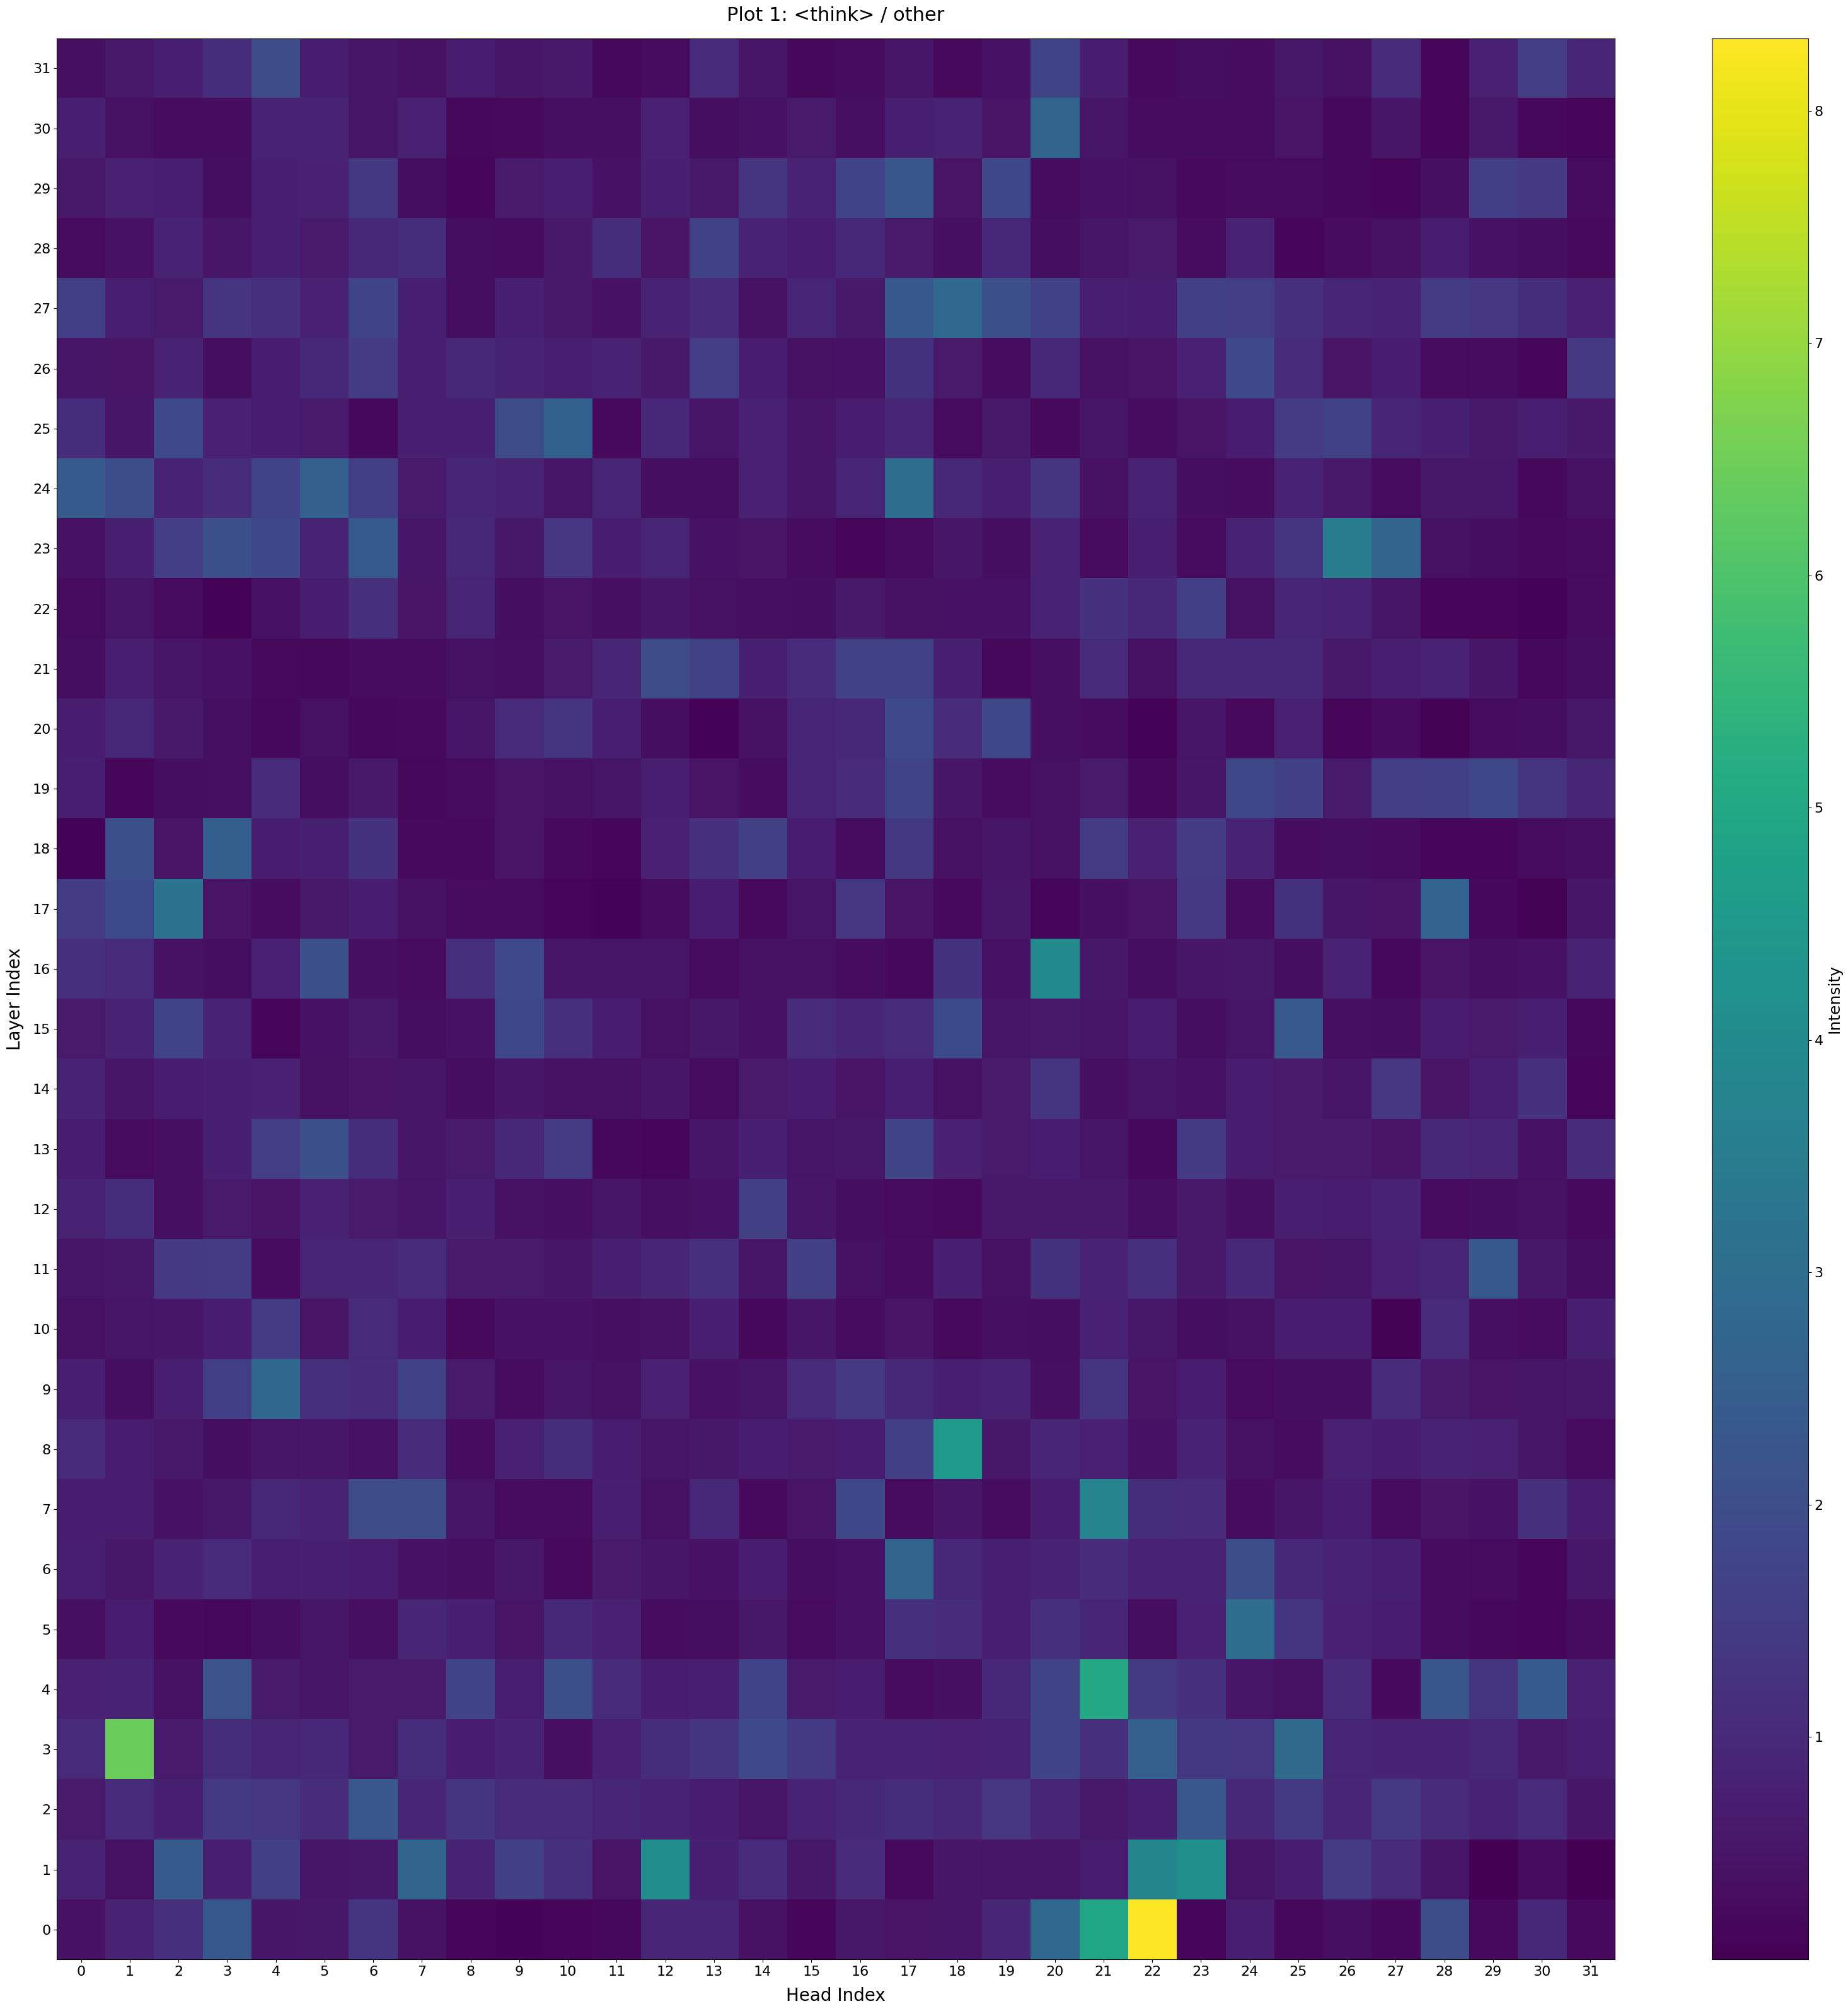

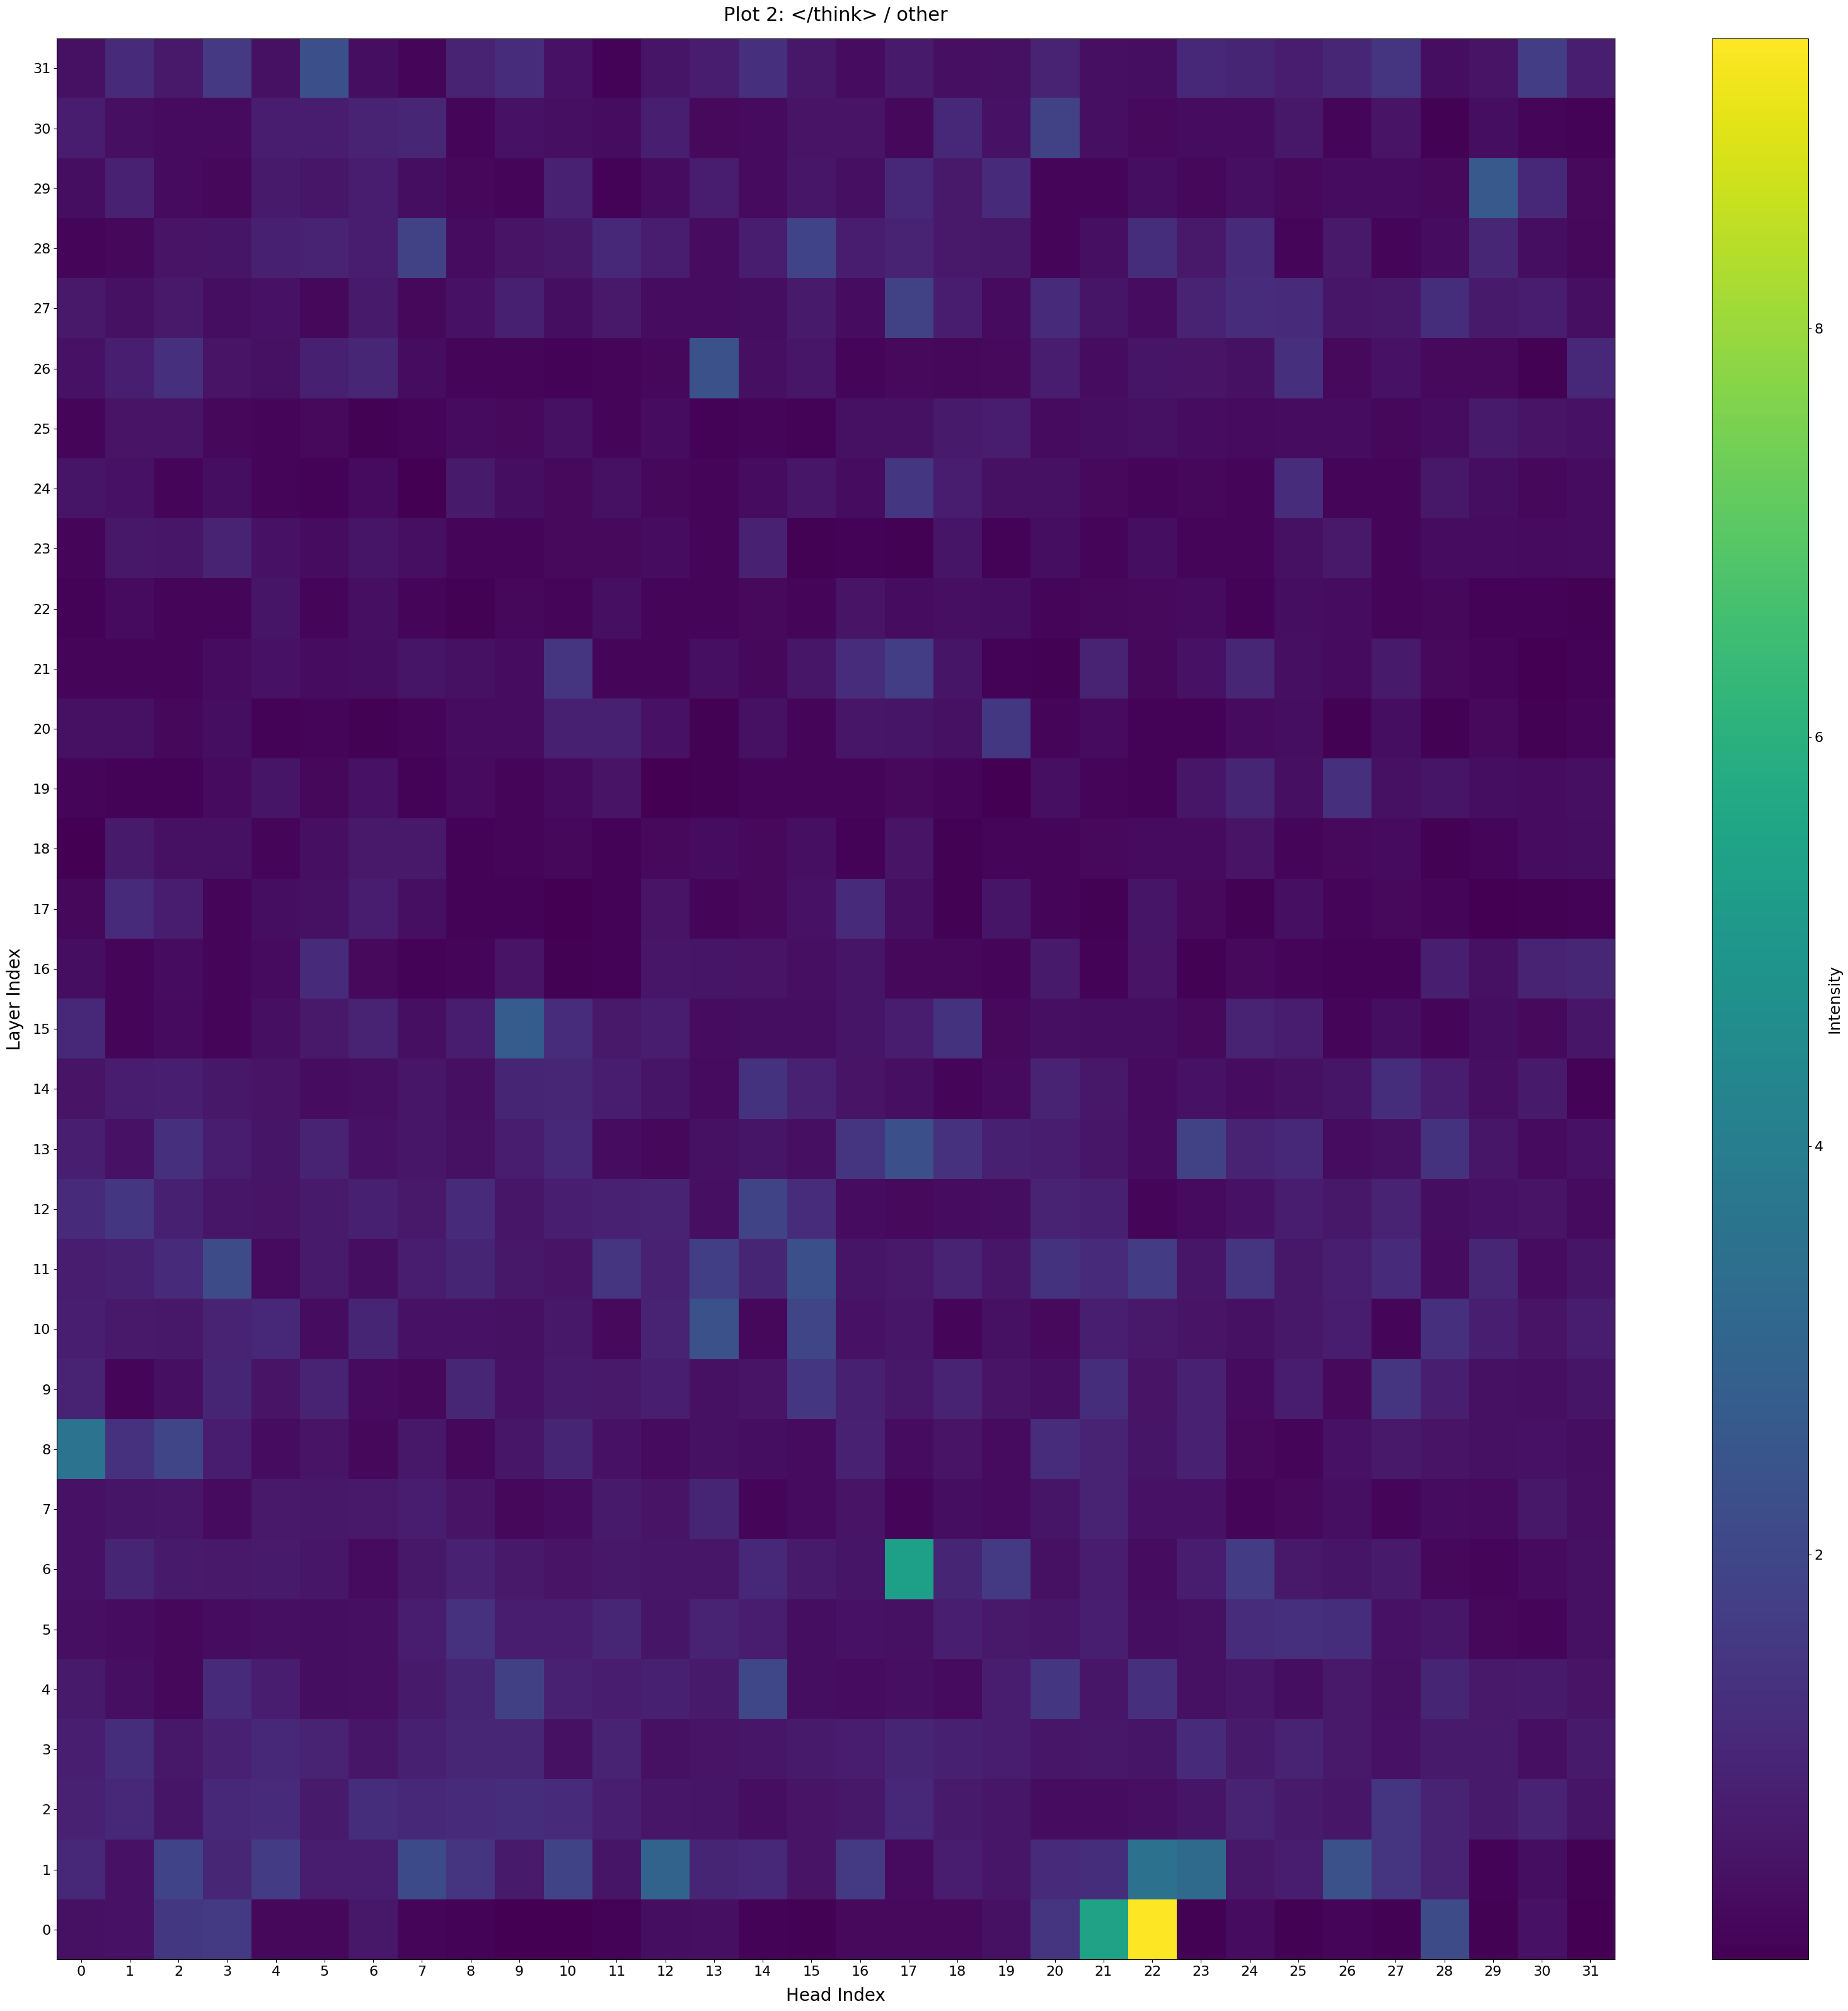

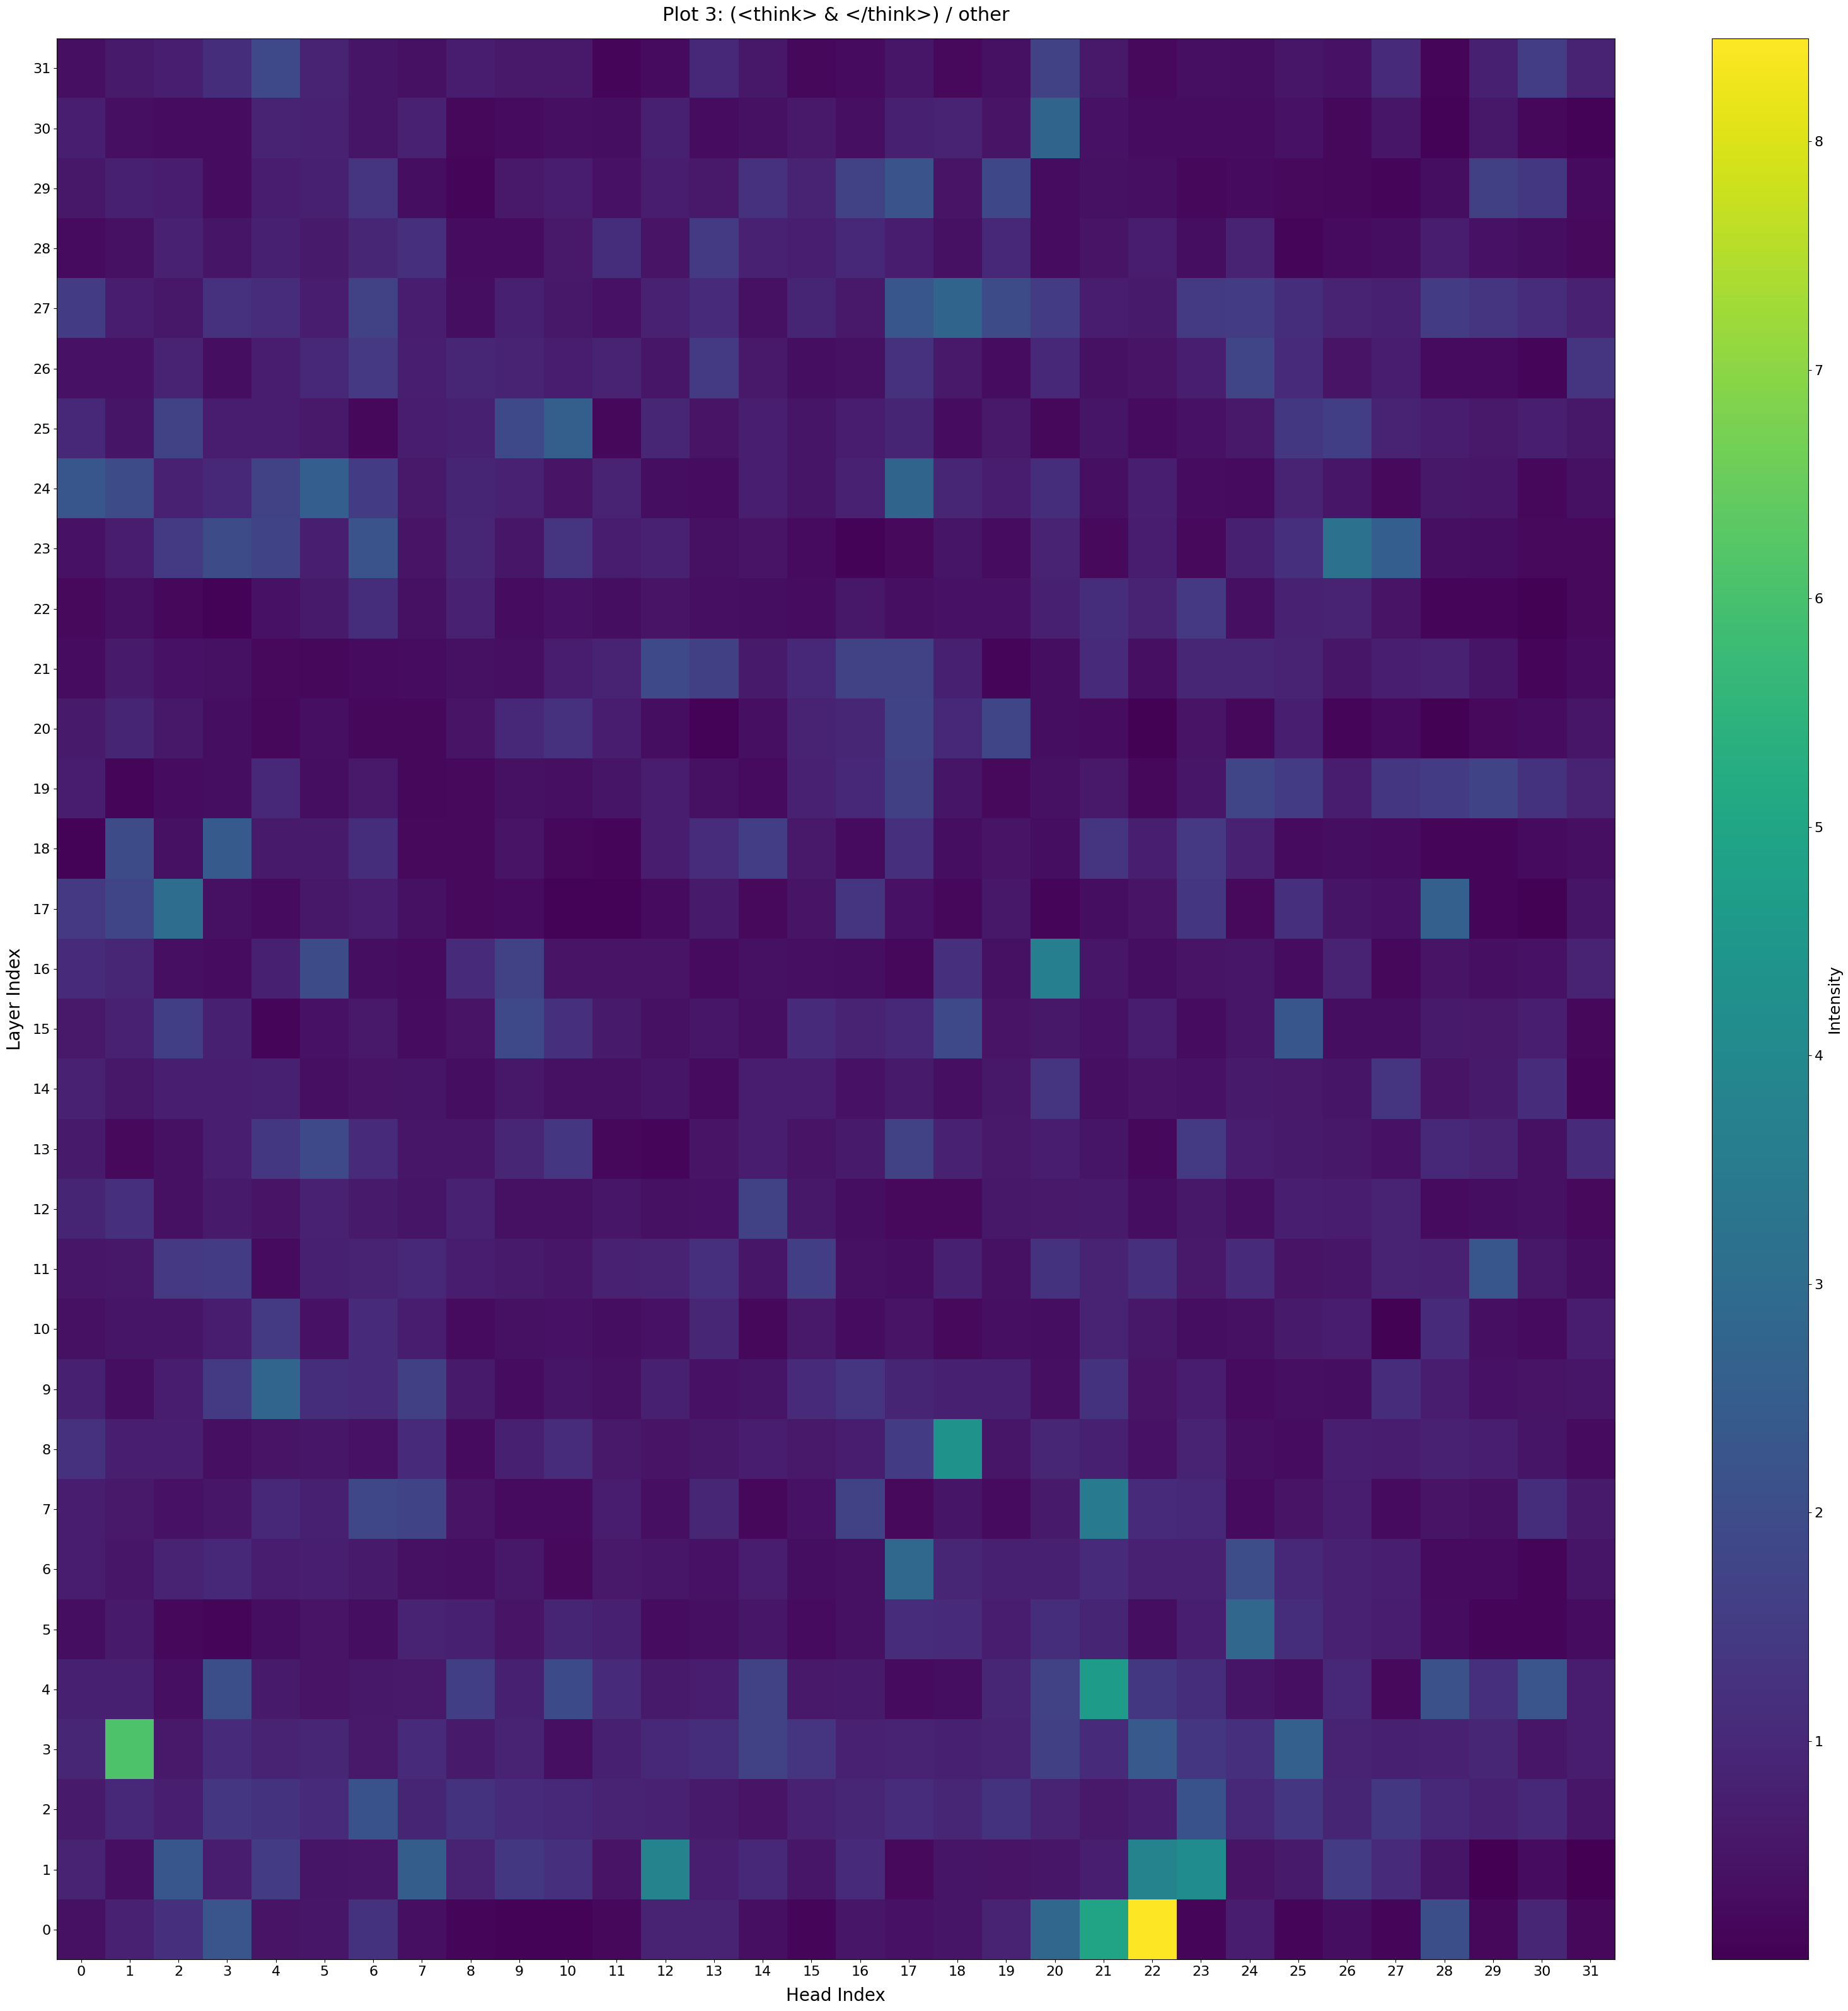

In [41]:
plot_ratios(collected_dict)

In [ ]:
jhg

In [ ]:
[i.item() for i in test_inputs[0] if i<128000]

[15960, 15960, 15960, 15960, 220, 220]

In [ ]:
test_logits, test_cache = baseline_model.run_with_cache(test_inputs, remove_batch_dim=True)

In [ ]:
attention_pattern = test_cache["pattern", 0, "attn"]

In [ ]:
attention_analysis(
        attention_array=attention_pattern[0].cpu().detach().numpy(), 
        think_indices=[1, 10], 
        stop_think_indices=[2, 8], 
        other_indices=[i for i, v in enumerate(test_inputs[0]) if v<128000]
    )

((np.float32(0.12017875),
  np.float32(0.082452096),
  np.float32(0.10049528),
  np.float32(0.11649856)),
 (np.float32(1.03159), np.float32(0.70775205), np.float32(0.8626311)))

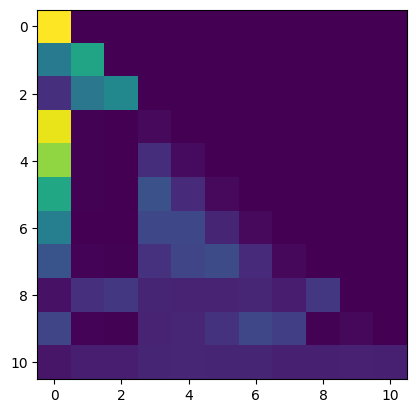

In [ ]:
plt.imshow(attention_pattern[0].cpu().detach().numpy())

In [ ]:
baseline_model.to_tokens("</think>")

tensor([[128000, 128014]], device='mps:0')

TypeError: can't convert mps:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

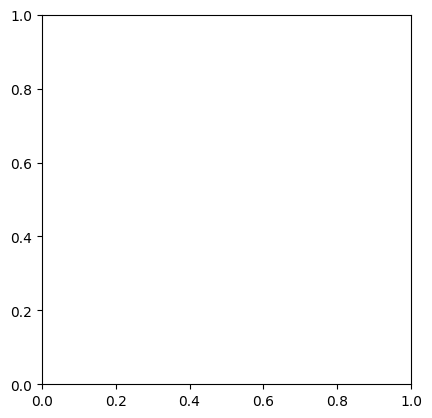

In [ ]:
plt.imshow(attention_pattern)

In [ ]:
attention_pattern.shape

torch.Size([32, 2, 2])

In [ ]:
import matplotlib.pyplot as plt 

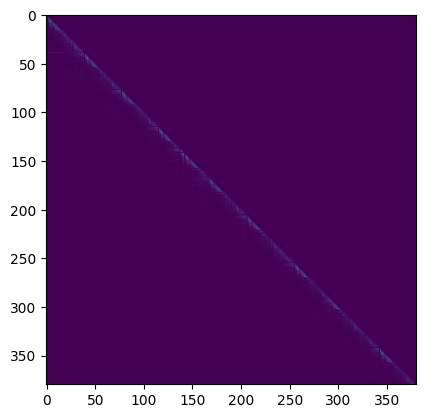

In [ ]:
plt.imshow(attention_pattern[0].cpu().detach().numpy())